<a href="https://colab.research.google.com/github/gouravchauhan712/code_clause_projects/blob/main/gender_and_age_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/UTF face.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
print(len(age_labels),len(gender_labels),len(image_paths),sep=",")

23708,23708,23708


In [ ]:
gender_mapping = {0:"Male",1:"Female"}

In [ ]:
data = pd.DataFrame()
data['image_path'],data['Age'],data['Gender'] = image_paths,age_labels,gender_labels
data

,image_path,Age,Gender
0,/content/UTKFace/90_0_0_20170111210753614.jpg....,90,0
1,/content/UTKFace/66_1_0_20170110160644001.jpg....,66,1
2,/content/UTKFace/31_1_1_20170116222848038.jpg....,31,1
3,/content/UTKFace/15_1_0_20170105000525758.jpg....,15,1
4,/content/UTKFace/47_0_0_20170117190246626.jpg....,47,0
...,...,...,...
23703,/content/UTKFace/26_1_4_20170117153702405.jpg....,26,1
23704,/content/UTKFace/24_0_1_20170113134042697.jpg....,24,0
23705,/content/UTKFace/28_0_0_20170117180611163.jpg....,28,0
23706,/content/UTKFace/26_0_1_20170116203607574.jpg....,26,0


Exploratory Data Analysis (EDA)

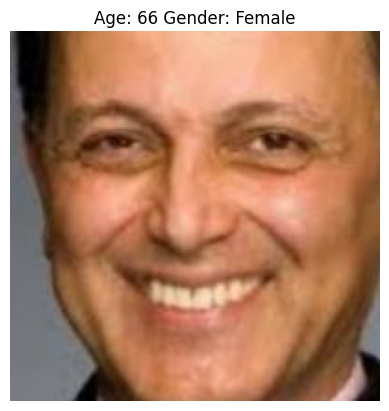

In [ ]:
from PIL import Image
age = data["Age"].iloc[1]
gender = data['Gender'].iloc[2]
Img = Image.open(data['image_path'][4])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis("off")
plt.imshow(Img)

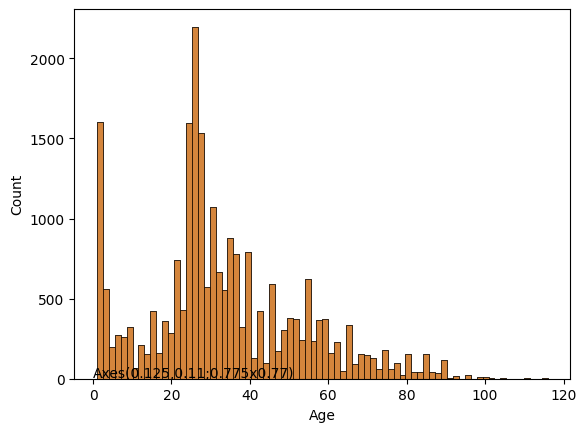

In [ ]:
sns.histplot(data["Age"])
plt.annotate(sns.histplot(data["Age"]),xy=(0,10))
plt.show()

<Axes: xlabel='Age', ylabel='Density'>

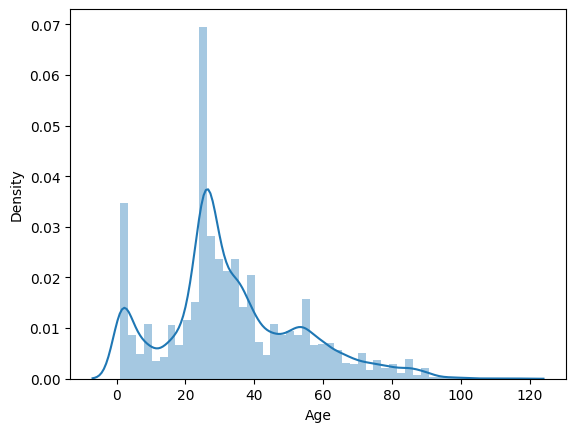

In [ ]:
sns.distplot(data["Age"])

Text(0.5, 1.0, 'Gender distribution')

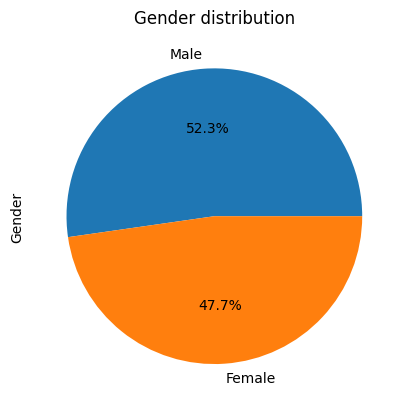

In [ ]:
gender_count = data['Gender'].value_counts()
gender_count.index = gender_count.index.map(gender_mapping)
gender_count.plot.pie(autopct='%1.1f%%')
plt.title('Gender distribution')


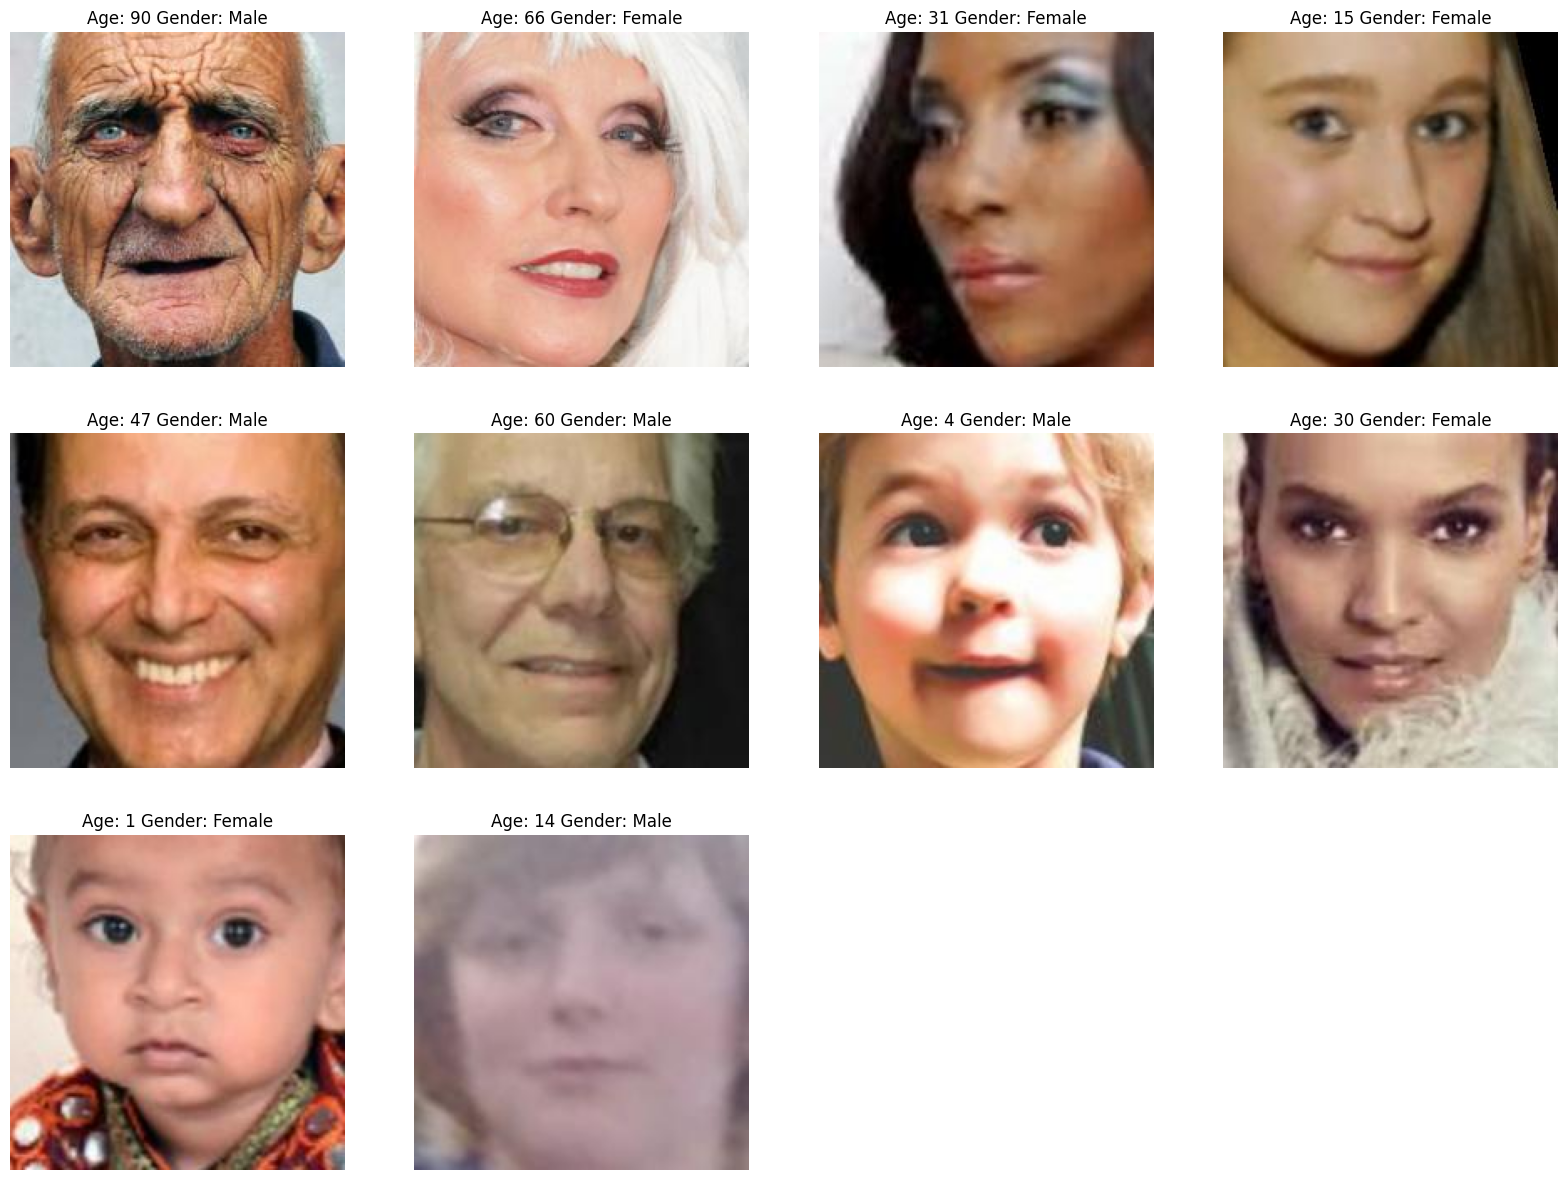

In [ ]:
plt.figure(figsize =(20,20))
images = data.iloc[0:10]
for index, sample, age, gender in images.itertuples():
    plt.subplot(4, 4,index+1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

Feature Extraction

In [ ]:
def extract_features(images):
    features = []
    for a in tqdm(images):
      img = load_img(a,grayscale=True)
      img = img.resize((128,128),Image.ANTIALIAS)
      img = np.array(img)
      features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),128,128,1)
    return features

X = extract_features(data['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X / 255

In [ ]:
y_gender = np.array(data['Gender'])
y_age = np.array(data['Age'])

In [ ]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

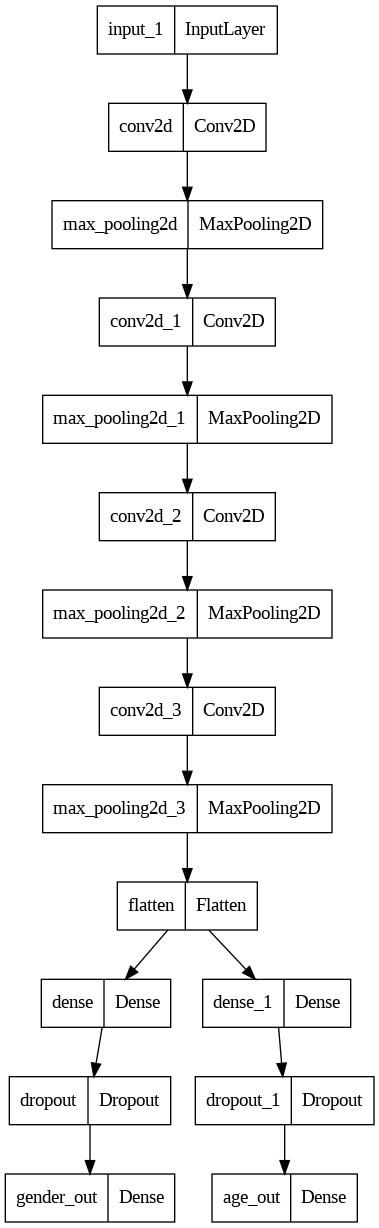

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model_fit = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 27s 23ms/step - loss: 15.4811 - gender_out_loss: 0.6793 - age_out_loss: 14.8018 - gender_out_accuracy: 0.5744 - age_out_accuracy: 0.0471 - val_loss: 12.8165 - val_gender_out_loss: 0.5760 - val_age_out_loss: 12.2404 - val_gender_out_accuracy: 0.7189 - val_age_out_accuracy: 0.0445
Epoch 2/50
593/593 [==============================] - 13s 22ms/step - loss: 11.2935 - gender_out_loss: 0.4791 - age_out_loss: 10.8144 - gender_out_accuracy: 0.7744 - age_out_accuracy: 0.0341 - val_loss: 9.8139 - val_gender_out_loss: 0.4451 - val_age_out_loss: 9.3688 - val_gender_out_accuracy: 0.7935 - val_age_out_accuracy: 0.0278
Epoch 3/50
593/593 [==============================] - 12s 21ms/step - loss: 9.4884 - gender_out_loss: 0.3950 - age_out_loss: 9.0934 - gender_out_accuracy: 0.8210 - age_out_accuracy: 0.0215 - val_loss: 8.5886 - val_gender_out_loss: 0.3654 - val_age_out_loss: 8.2232 - val_gender_out_accuracy: 0.8321 - val_age_out_accuracy: 0.0175
Epoc

Plot Results Graph

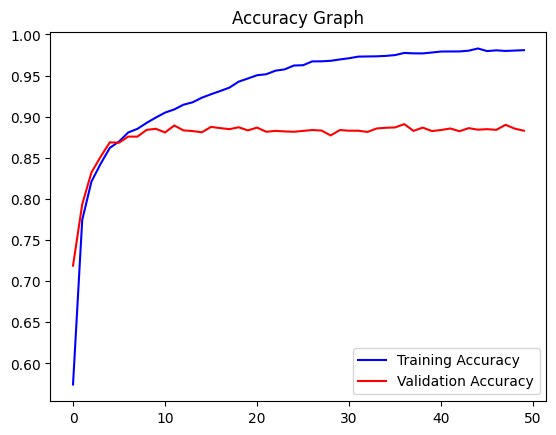

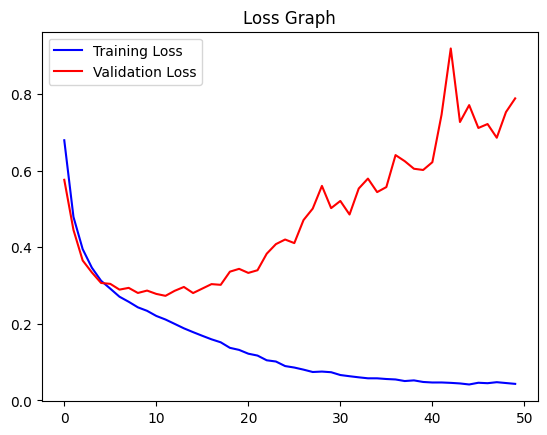

In [ ]:
# plot results for gender
acc = model_fit.history['gender_out_accuracy']
val_acc = model_fit.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = model_fit.history['gender_out_loss']
val_loss = model_fit.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Testing Model

In [ ]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 18ms/step


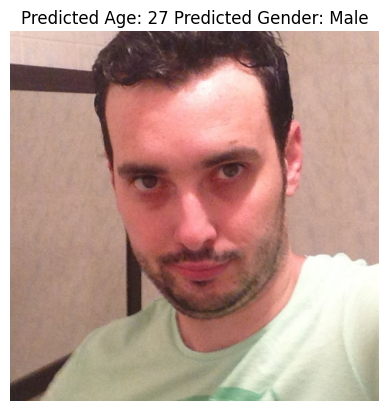

In [28]:
img_to_test = '/content/test.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))